# Transform 2021: GemPy Workshop
![image.png](https://raw.githubusercontent.com/cgre-aachen/gempy/master/docs/readme_images/header_combined_slim.png)

## Table of Content

- Installation - Welcome 
- Basics Refresher (~25 mins)
- Intro to `subsurface` (~ 25 mins)
- **Break** (~ 10 mins)
- `subsurface` to `gempy` (~ 25 mins)
- Dealing with complexity (~ 25 mins)


## Installation

0. https://docs.conda.io/en/latest/miniconda.html
1. Open conda prompt (Windows) or terminal (Linux/MacOS)
2. `$ conda create --name gempy-tutorial python==3.8.5`
0. Activate enviromet: `$ conda activate gempy-tutorial`
3. Installing gempy: https://docs.gempy.org/installation.html
4. clone the repo:
    `git clone https://github.com/cgre-aachen/gempy_workshops.git`
0. `$ conda install jupyter notebook`
5. `$ jupyter notebook`

# Part I: Your first model (refresher)

In [1]:
# List of relative paths used during the workshop
path_to_well_png     = '../../common/basics/data/wells.png'
path_to_checkpoint_1 = '../../common/basics/checkpoints/checkpoint1.pickle'
path_to_checkpoint_2 = '../../common/basics/checkpoints/checkpoint2.pickle'
upgrade_pickles = False

In [2]:
# Importing GemPy
import gempy as gp

# Importing aux libraries
from ipywidgets import interact
import numpy as np
import matplotlib.image as mpimg

# Embedding matplotlib figures in the notebooks
%matplotlib qt5

### Initializing the model... But first a word about Grids:

The first step to create a GemPy model is create a `gempy.Model` object that will
contain all the other data structures and necessary functionality. In addition
 for this example we will define a *regular grid* since the beginning.
This is the grid where we will interpolate the 3D geological model.

GemPy is based on a **meshless interpolator**. In practice this means that we can
interpolate any point in a 3D space. However, for convenience, we have built some
standard grids for different purposes. At the current day the standard grids are:

- **Regular grid**: default grid mainly for general visualization
- **Custom grid**: GemPy's wrapper to interpolate on a user grid
- **Topography**: Topographic data use to be of high density. Treating it as an independent
  grid allow for high resolution geological maps
- **Sections**: If we predefine the section 2D grid we can directly interpolate at those
  locations for perfect, high resolution estimations
- **Center grids**: Half sphere grids around a given point at surface. This are specially tuned
  for geophysical forward computations

For now we will use a 2.5D regular grid

In [3]:
geo_model = gp.create_model('Transform-2021')
geo_model = gp.init_data(geo_model,
                         extent= [0, 791, 0, 200, -582, 0], # of the regular grid
                         resolution=[100, 10, 100])         # of the regular grid

Active grids: ['regular']


GemPy core code is written in Python. However for efficiency and gradient based
machine learning most of heavy computations happen in optimize compile code,
 either C or CUDA for GPU.

To do so, GemPy rely on the library `Theano`. To guarantee maximum optimization
`Theano` requires to compile the code for every Python kernel. The compilation is
done by calling the following line at any point (before computing the model):

In [4]:
gp.set_interpolator(
    geo_model,
    output=['geology'], # In built outputs. More about this later on
    theano_optimizer='fast_compile') # alternatives: 'fast_run' or
                                     # check http://deeplearning.net/software/theano/tutorial/modes.html                        

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                        values
range              1002.20008
$C_o$            23914.404762
drift equations           [3]


### Creating figure:

GemPy uses `matplotlib` and `pyvista` for 2d and 3d visualization of the model respectively. One of the
design decisions of GemPy is to allow real time construction of the model. What this means is that you can start
adding input data and see in real time how the 3D surfaces evolve. Lets initialize the visualization windows.

The first one is the 2d figure. Just place the window where you can see it (maybe move the jupyter notebook to half
screen and use the other half for the renderers).

In [5]:
p2d = gp.plot_2d(geo_model, section_names=None,
                 direction=None, cell_number=None)
p2d.fig

<Figure size 640x480 with 0 Axes>

#### Add model section

In the 2d renderer we can add several cross section of the model. In this case, for simplicity sake we are just
adding one perpendicular to y.

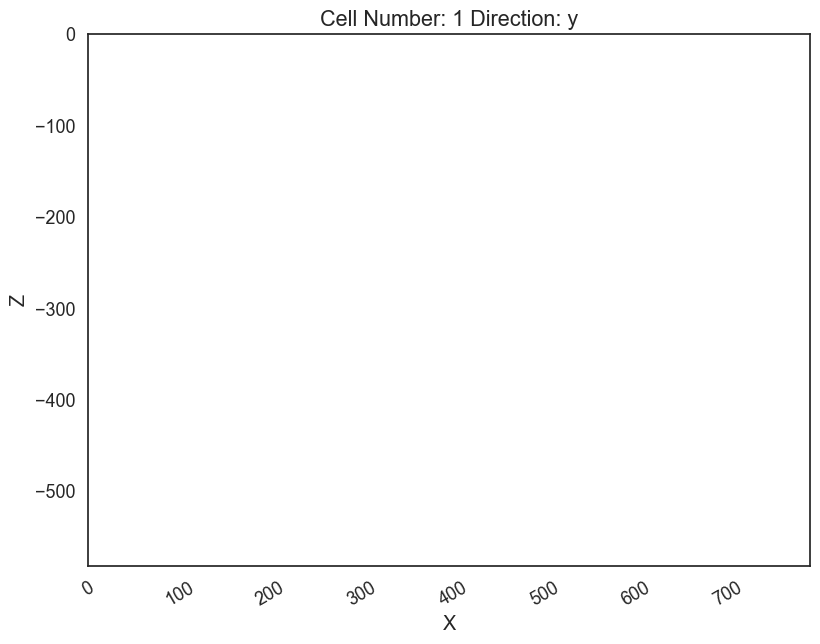

In [6]:
import matplotlib.pyplot as plt
# In this case perpendicular to the y axes
ax = p2d.add_section(cell_number=1, direction='y')
p2d.fig

#### Loading cross-section image:

Remember that `gempy` is simply using `matplotlib` and therefore the ax object
 created above is a standard `matplotlib` axes.

Lets load an image with the information of couple of boreholes

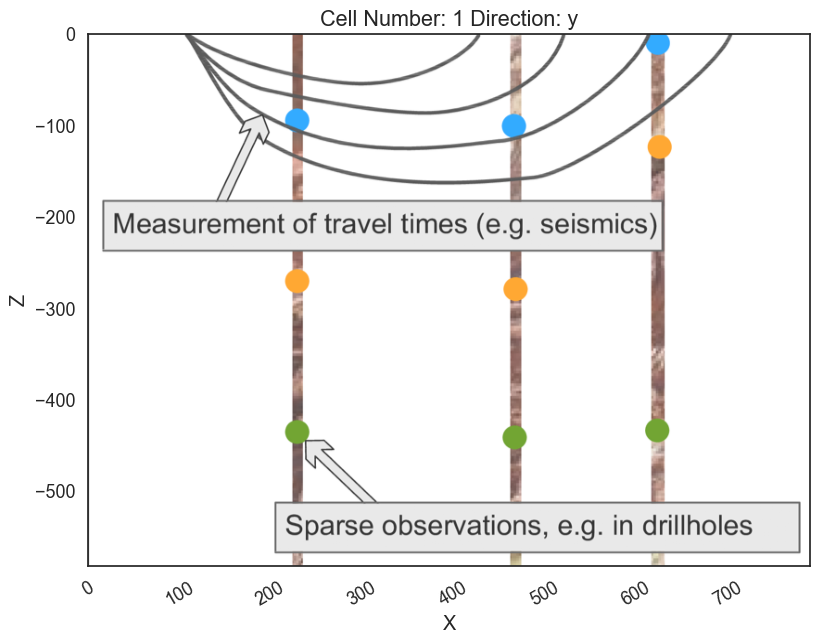

In [7]:
# Reading image
img = mpimg.imread(path_to_well_png)
# Plotting it inplace
ax.imshow(img, origin='upper', alpha=.8, extent = (0, 791, -582,0))
p2d.fig

We can do the same in 3D through `pyvista` and vtk rendering.

Click the qt5 button Back (+Y) to have the same view as in the 2D viewer:

In [8]:
p3d = gp.plot_3d(geo_model, plotter_type='background', notebook=False)

In [10]:
# Small function to display screenshots in the notebook
def plot_pyvista_to_notebook(pyvista_plot):
    img = pyvista_plot.screenshot()
    fig = plt.Figure(frameon=False)
    ax_suplot= fig.add_subplot()
    ax_suplot.axis("off")
    ax_suplot.imshow(img)
    return fig

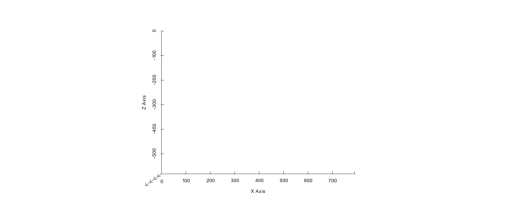

In [14]:
plot_pyvista_to_notebook(p3d.p)

## Building the model

Now that we have the model initialize and the 2D and 3D render in place we can
 start the construction of the geological model. 

### Surfaces

GemPy is a surface based interpolator. This means that all the input data we add has to be refereed to a surface. The
 surfaces always mark the **bottom** of a unit. 
 
 By default GemPy surfaces are empty:

In [15]:
geo_model.surfaces

,surface,series,order_surfaces,color,id


If we do not care about the names and we just want to interpolate a surface we can use.
It is important to notice that **the bottom
most layer will be considered always basement and therefore not interpolated**. Still
we can add values or change the color of that "surface" (for lack of a better name) to
populate the lower most volume.


In [16]:
# Default surfaces:
geo_model.set_default_surfaces()

,surface,series,order_surfaces,color,id
0,surface1,Default series,1,#015482,1
1,surface2,Default series,2,#9f0052,2


We will see more about data structures below.

Now we can start adding data. GemPy input data consist on surface points and
orientations (perpendicular to the layers). The 2D plot gives you the X and Z coordinates when hovering the mouse
 over. We can add a surface point as follows:


In [17]:
# Add a point. If idx is None, next available index will be used. Here we pass it
# explicitly for consistency
geo_model.add_surface_points(X=223, Y=0.01, Z=-94,
                             surface='surface1', idx=0)

# Plot in 2D
p2d.plot_data(ax, cell_number=11)

# Plot in 3D
p3d.plot_data()

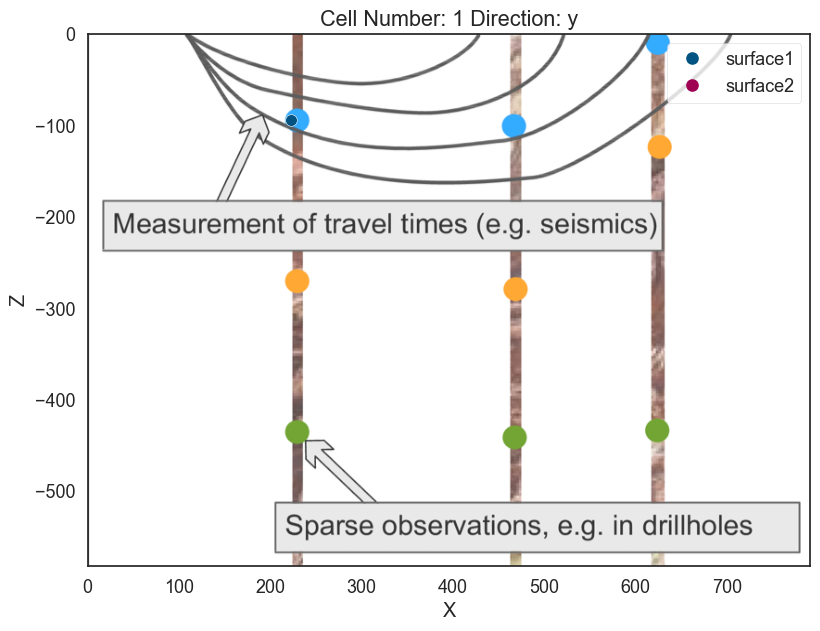

In [15]:
p2d.fig

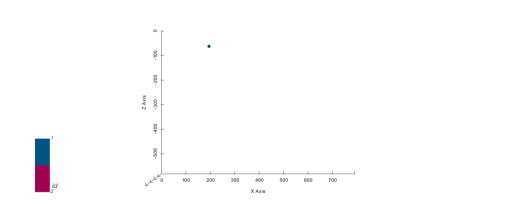

In [21]:
plot_pyvista_to_notebook(p3d.p)

Now we can add the other two points of the layer:

In [22]:
# Add points
geo_model.add_surface_points(X=458, Y=0, Z=-107, surface='surface1', idx=1)
geo_model.add_surface_points(X=612, Y=0, Z=-14, surface='surface1', idx=2)

# Plotting
p2d.plot_data(ax, cell_number=11)
p3d.plot_surface_points()

(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)0000028F0117BE20

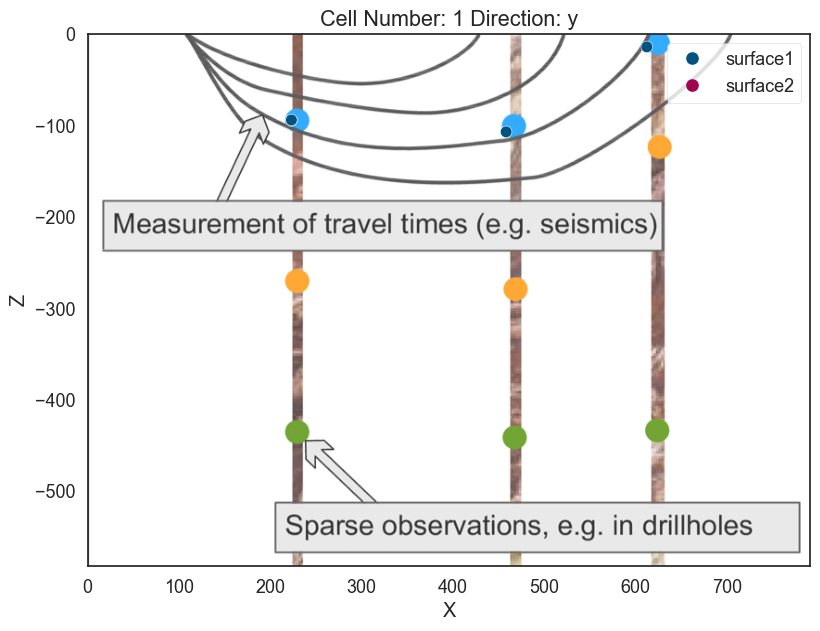

In [18]:
p2d.fig

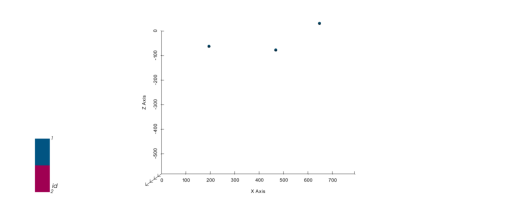

In [23]:
plot_pyvista_to_notebook(p3d.p)

In [24]:
geo_model.surface_points

,X,Y,Z,smooth,surface
0,223.0,0.01,-94.0,0.000001,surface1
1,458.0,0.00,-107.0,0.000001,surface1
2,612.0,0.00,-14.0,0.000001,surface1


The **minimum amount of input data** to interpolate anything in `gempy` is:

a) 2 surface points per surface

b) One orientation per series.

Lets add an orientation anywhere in space:

In [25]:
# Adding orientation
geo_model.add_orientations(X=350, Y=0, Z=-300, surface='surface1',
                           pole_vector= (0,0,1))
p2d.plot_data(ax, cell_number=5)
p3d.plot_data()

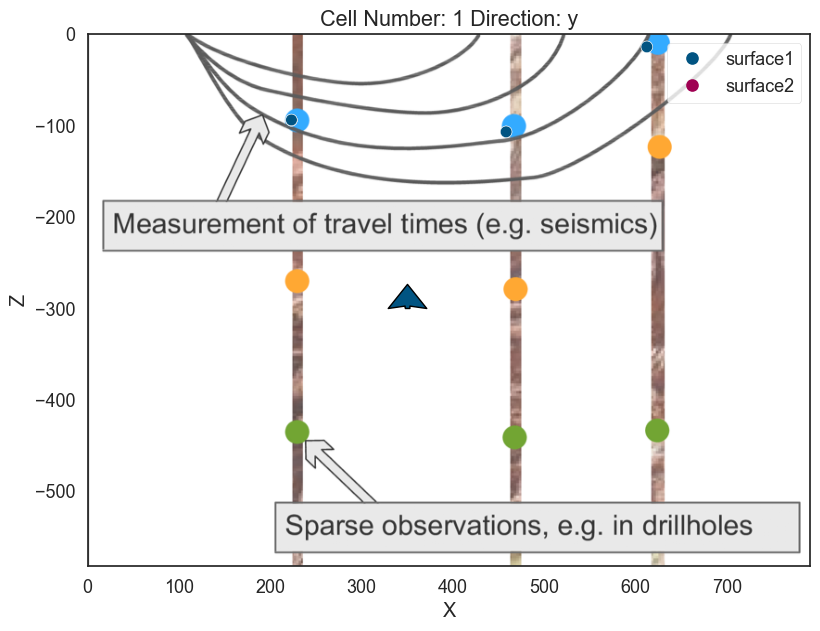

In [26]:
p2d.fig

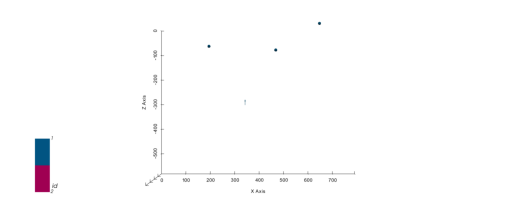

In [27]:
plot_pyvista_to_notebook(p3d.p)

Now we have enough data to finally **interpolate**!

In [28]:
gp.compute_model(geo_model)


Lithology ids 
  [2. 2. 2. ... 2. 2. 2.] 

That is, we have interpolated the 3D surface. We can visualize with:

In [29]:
# In 2D
p2d.plot_contacts(ax, cell_number=5)

# In 3D
p3d.plot_surfaces()
p3d.plot_structured_grid()

[StructuredGrid (0x28f067aba00)
   N Cells:	88209
   N Points:	100000
   X Bounds:	3.955e+00, 7.870e+02
   Y Bounds:	1.000e+01, 1.900e+02
   Z Bounds:	-5.791e+02, -2.910e+00
   Dimensions:	100, 10, 100
   N Arrays:	2,

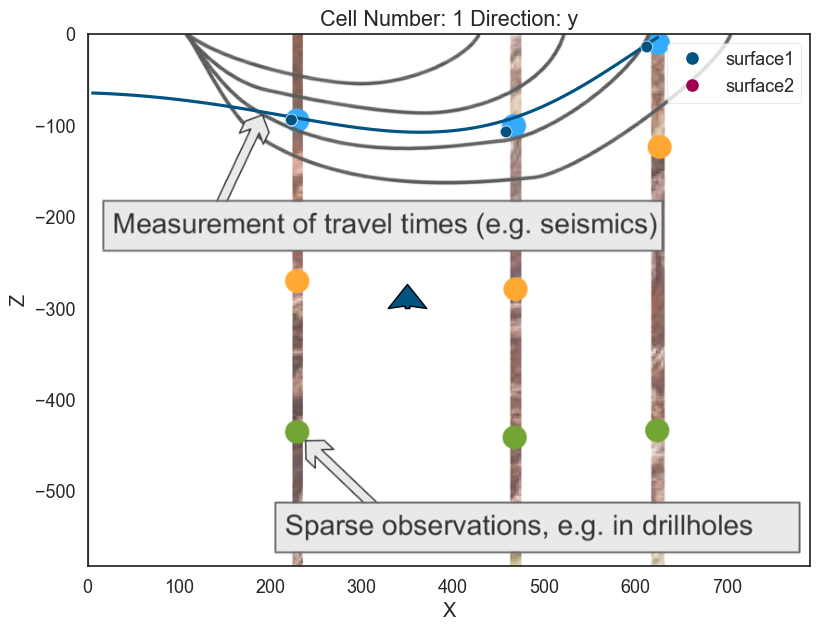

In [30]:
p2d.fig

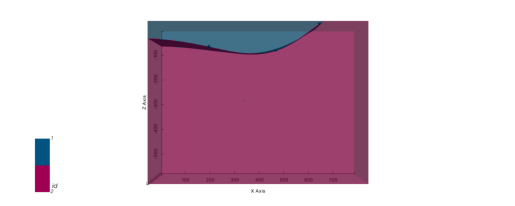

In [31]:
plot_pyvista_to_notebook(p3d.p)

In [32]:
geo_model.solutions.lith_block

array([2., 2., 2., ..., 2., 2., 2.])

In [33]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,surface1,Default series,1,#015482,1
1,surface2,Default series,2,#9f0052,2


Congratulations! You have learnt how to create a surface. From here on, we will
learn how to combine multiple surfaces to little by little construct a full realize
3D structural model.

-----------
## Intermission: GemPy data classes

GemPy depends on multiple data objects to store all the data structures necessary
to construct an structural model. To keep all the necessary objects in sync the
class `gempy.ImplicitCoKriging` (which `geo_model` is instance of) will provide the
necessary methods to update these data structures coherently.

At current state (gempy 2.2), the data classes are:

- `gempy.SurfacePoints`
- `gempy.Orientations`
- `gempy.Surfaces`
- `gempy.Stack` (combination of `gempy.Series` and `gempy.Faults`)
- `gempy.Grid`
- `gempy.AdditionalData`
- `gempy.Solutions`

Today we will look into details only some of these classes but what is important
to notice is that you can access these objects as follows:

In [34]:
# The default surfaces once again
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,surface1,Default series,1,#015482,1
1,surface2,Default series,2,#9f0052,2


In [35]:
# Also the surface points
geo_model.surface_points

,X,Y,Z,smooth,surface
0,223.0,0.01,-94.0,0.000001,surface1
1,458.0,0.00,-107.0,0.000001,surface1
2,612.0,0.00,-14.0,0.000001,surface1


In [36]:
# Orientations
geo_model.orientations

,X,Y,Z,G_x,G_y,G_z,smooth,surface
0,350.0,0.0,-300.0,0.0,0.0,1.0,0.01,surface1


In [37]:
# To find the location of the surface we just plot
geo_model.solutions.vertices

[array([[  3.955     ,  10.        , -64.28490875],
        [  3.955     ,  30.        , -64.3000058 ],
        [ 11.865     ,  10.        , -64.6319632 ],
        ...,
        [624.85240288, 110.        ,  -2.91      ],
        [623.23234711, 130.        ,  -2.91      ],
        [621.12407188, 150.        ,  -2.91      ]])]

In [38]:
# The grid values:
geo_model.grid, len(geo_model.grid.values)

(Grid Object. Values: 
 array([[   3.955,   10.   , -579.09 ],
        [   3.955,   10.   , -573.27 ],
        [   3.955,   10.   , -567.45 ],
        ...,
        [ 787.045,  190.   ,  -14.55 ],
        [ 787.045,  190.   ,   -8.73 ],
        [ 787.045,  190.   ,   -2.91 ]]),
 100000)

In [39]:
# And its correspondent ids:
geo_model.solutions.lith_block, len(geo_model.solutions.lith_block)

(array([2., 2., 2., ..., 2., 2., 2.]), 100000)

------

## Adding more layers

<div class="alert alert-block alert-warning">
<b>Exercise:</b> So far we only need 2 units defined. The cross-section image that
 we load have 4 however. Lets add two layers more:
</div>

### Layer 2

First we need to add some more layers.

In [40]:
# We can add already two extra surfaces
geo_model.add_surfaces(['surface3', 'basement'])

,surface,series,order_surfaces,color,id
0,surface1,Default series,1,#015482,1
1,surface2,Default series,2,#9f0052,2
2,surface3,Default series,3,#ffbe00,3
3,basement,Default series,4,#728f02,4


In [41]:
# Your code here:
geo_model.add_surface_points(X=225, Y=0, Z=-269, surface='surface2', idx=3)
geo_model.add_surface_points(X=459, Y=0, Z=-279, surface='surface2', idx=4)

#--------------------
# Plot data
p2d.plot_data(ax)
p3d.plot_data()

In [42]:
# Compute model
gp.compute_model(geo_model)

# Plot 2D
p2d.plot_lith(ax, cell_number=5)
p2d.plot_contacts(ax, cell_number=5)

# Plot 3D
p3d.plot_surfaces()
p3d.plot_structured_grid(opacity=.2, annotations = {1: 'surface1', 2:'surface2', 3:'surface3'})


[StructuredGrid (0x28f067aba00)
   N Cells:	88209
   N Points:	100000
   X Bounds:	3.955e+00, 7.870e+02
   Y Bounds:	1.000e+01, 1.900e+02
   Z Bounds:	-5.791e+02, -2.910e+00
   Dimensions:	100, 10, 100
   N Arrays:	2,

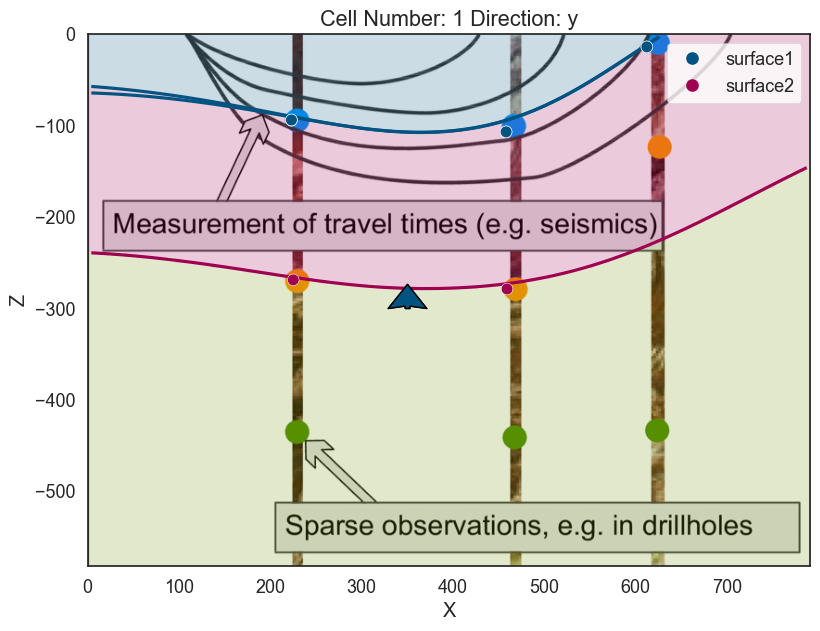

In [43]:
p2d.fig

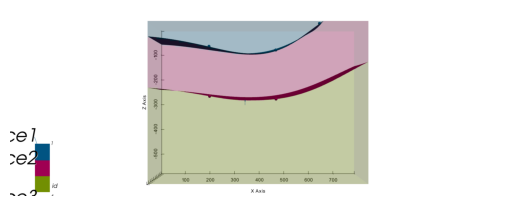

In [45]:
plot_pyvista_to_notebook(p3d.p)

### Layer 3

In [46]:
# Your code here:
# Add points
geo_model.add_surface_points(X=225, Y=0, Z=-439, surface='surface3')
geo_model.add_surface_points(X=464, Y=0, Z=-456, surface='surface3')
geo_model.add_surface_points(X=619, Y=0, Z=-433, surface='surface3')

# Compute model
gp.compute_model(geo_model)

# Plotting
p2d.plot_data(ax, cell_number=5)
p2d.plot_lith(ax, cell_number=5)
p2d.plot_contacts(ax, cell_number=5)

p3d.plot_surfaces()
p3d.plot_structured_grid(opacity=.2, annotations = {1: 'surface1', 2:'surface2', 3:'surface3', 4:'basement'})
p3d.plot_data()
# ------------------

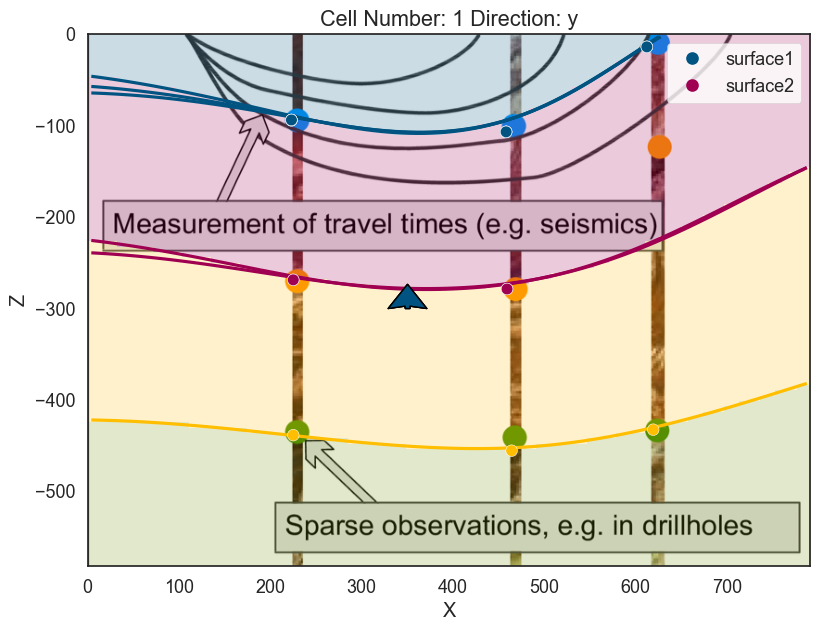

In [47]:
p2d.fig

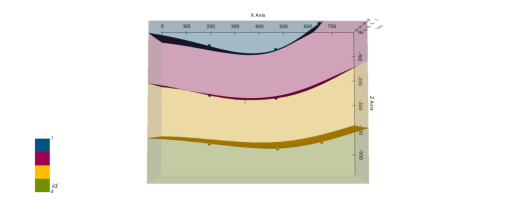

In [50]:
plot_pyvista_to_notebook(p3d.p)

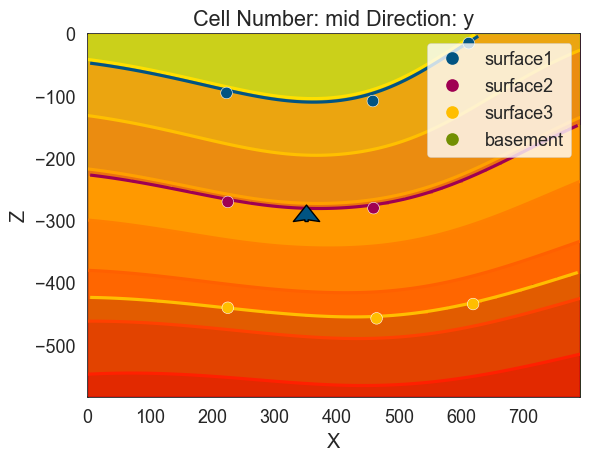

In [51]:
# Showing scalar field
scalar = gp.plot_2d(geo_model, show_scalar=True, series_n=0)
scalar.fig

-------------------
## Intermission: GemPy data structures: Surfaces Points, Orientations and surfaces

On GemPy each surface is not independent of each other. Some surfaces will be
subparallel to each other while other surfaces will define a fault plane where
an offset may occur.

In order to account for all possible combinations, we use **categories** (in many
instances literal `pandas.CategoricalDtype`) and **ordered** `pandas.Dataframes`.
Let's take a look at `gempy.SurfacePoints`:

In [52]:
geo_model.surface_points

,X,Y,Z,smooth,surface
0,223.0,0.01,-94.0,0.000001,surface1
1,458.0,0.00,-107.0,0.000001,surface1
2,612.0,0.00,-14.0,0.000001,surface1
3,225.0,0.00,-269.0,0.000001,surface2
4,459.0,0.00,-279.0,0.000001,surface2
5,225.0,0.00,-439.0,0.000001,surface3
6,464.0,0.00,-456.0,0.000001,surface3
7,619.0,0.00,-433.0,0.000001,surface3


As we can see each point belong to a given surface. If now we look at the
`gempy.Surface` object:

In [53]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,surface1,Default series,1,#015482,1
1,surface2,Default series,2,#9f0052,2
2,surface3,Default series,3,#ffbe00,3
3,basement,Default series,4,#728f02,4


Here we can find the properties related to a each surface. Special attention
to the column series. At the moment all surfaces belong to the same series
and therefore they will be interpolated together in that characteristic subparallel
pattern.

Now we will see how by playing with the series we can define unconformities and
faults

--------------

<div class="alert alert-block alert-info"><b>Checkpoint:</b> Next cell will load the
model from disk to the necessary state to continue.</div>

---------
## Unconformities and Faults:

So far the model is simply a depositional unit. GemPy allows for unconformities
and faults to build complex models. This input is given by categorical data. In general:

**Geometric Data** (surface points/ orientations) <belong to< **surface** <belong to< **series**

And series can be a fault---i.e. offset the rest of surface--- or not. We are going to show how to add a fault as an example.

First we need to add a series:

### Erosion

In [54]:
geo_model.add_features('Discontinuity')

,order_series,BottomRelation,isActive,isFault,isFinite
Default series,1,Erosion,True,False,False
Discontinuity,2,Erosion,False,False,False


Now there are two different series/features but not a surface that belong to it.
Therefore, we also need to add a new surface:

In [55]:
geo_model.add_surfaces('discontinuity1')

,surface,series,order_surfaces,color,id
0,surface1,Default series,1,#015482,1
1,surface2,Default series,2,#9f0052,2
2,surface3,Default series,3,#ffbe00,3
3,basement,Default series,4,#728f02,4
4,discontinuity1,Discontinuity,1,#443988,5


Linking series/feature with surface:

In [56]:
gp.map_stack_to_surfaces(geo_model, {'Discontinuity':'discontinuity1'})


,surface,series,order_surfaces,color,id
0,surface1,Default series,1,#015482,1
1,surface2,Default series,2,#9f0052,2
2,surface3,Default series,3,#ffbe00,3
3,basement,Default series,4,#728f02,4
4,discontinuity1,Discontinuity,1,#443988,5


Notice that by default it is defining an erosion.

In [57]:
geo_model.reorder_features(['Discontinuity', 'Default series'])

,order_series,BottomRelation,isActive,isFault,isFinite
Discontinuity,1,Erosion,False,False,False
Default series,2,Erosion,True,False,False


In [58]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
4,discontinuity1,Discontinuity,1,#443988,1
0,surface1,Default series,1,#015482,2
1,surface2,Default series,2,#9f0052,3
2,surface3,Default series,3,#ffbe00,4
3,basement,Default series,4,#728f02,5


Now we can just add input data as before (remember the minimum amount of input data to compute a model):

In [60]:
# Add input data of the fault
geo_model.add_surface_points(X=550, Y=0, Z=-30, surface='discontinuity1')
geo_model.add_surface_points(X=650, Y=0, Z=-200, surface='discontinuity1')
geo_model.add_orientations(X=600, Y=0, Z= -100, surface='discontinuity1',
                           pole_vector=(.3,0,.3))
# Plot
p2d.remove(ax)
p2d.plot_data(ax, cell_number=5)
p3d.remove_actor(p3d.regular_grid_actor) # Removing the previous regular grid because
                                         # we are changing the colors and gets messy
p3d.plot_data()

If we compute now the model the purple plane will erode the previous surfaces
and layers:

In [61]:
# Compute
gp.compute_model(geo_model)

# Plot
p2d.remove(ax)
p2d.plot_data(ax, cell_number=5)
p2d.plot_lith(ax, cell_number=5)
p2d.plot_contacts(ax, cell_number=5)

p3d.plot_data()
p3d.plot_surfaces()
p3d.plot_structured_grid(opacity=.2, annotations = {2: 'surface1', 3:'surface2',
                                                    4:'surface3', 5:'basement'})

[StructuredGrid (0x28f067aba00)
   N Cells:	88209
   N Points:	100000
   X Bounds:	3.955e+00, 7.870e+02
   Y Bounds:	1.000e+01, 1.900e+02
   Z Bounds:	-5.791e+02, -2.910e+00
   Dimensions:	100, 10, 100
   N Arrays:	3,

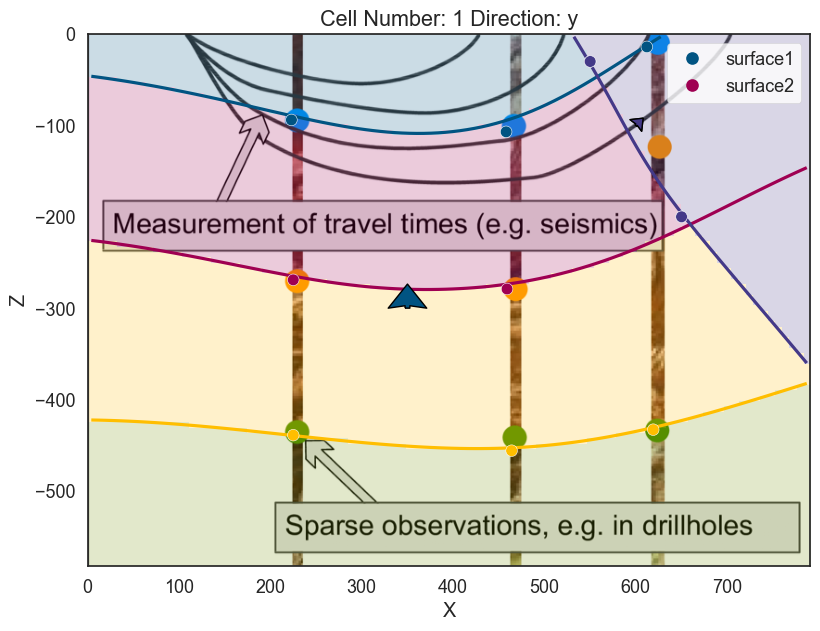

In [62]:
p2d.fig

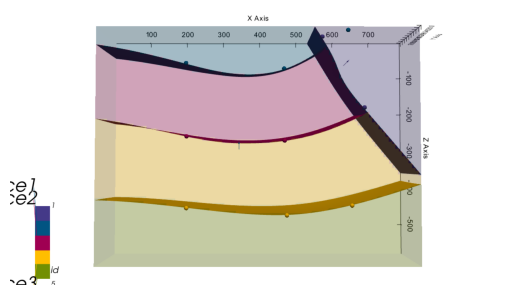

In [63]:
plot_pyvista_to_notebook(p3d.p)

In [64]:
geo_model.stack

,order_series,BottomRelation,isActive,isFault,isFinite
Discontinuity,1,Erosion,True,False,False
Default series,2,Erosion,True,False,False


### Onlap

If the relation should be onlap we just need to change the type of series/feature
of discontinuity

In [67]:
geo_model.set_bottom_relation('Discontinuity', 'Onlap')


# %%
# Compute
gp.compute_model(geo_model)

# Plot
p2d.remove(ax)
p2d.plot_data(ax, cell_number=5)
p2d.plot_lith(ax, cell_number=5)
p2d.plot_contacts(ax, cell_number=5)

p3d.plot_data()
p3d.plot_structured_grid(opacity=.2, annotations = {2: 'surface1', 3:'surface2',
                                                    4:'surface3', 5:'basement'})

w:\miniconda\envs\gempy-tutorial\lib\site-packages\gempy\core\solution.py:353: UserWarning: Surfaces not computed due to: No surface found at the given iso value.. The surface is: Series: No surface found at the given iso value.; Surface Number:2
  warnings.warn('Surfaces not computed due to: ' + str(
w:\miniconda\envs\gempy-tutorial\lib\site-packages\gempy\core\solution.py:353: UserWarning: Surfaces not computed due to: No surface found at the given iso value.. The surface is: Series: No surface found at the given iso value.; Surface Number:3
  warnings.warn('Surfaces not computed due to: ' + str(


[StructuredGrid (0x28f067aba00)
   N Cells:	88209
   N Points:	100000
   X Bounds:	3.955e+00, 7.870e+02
   Y Bounds:	1.000e+01, 1.900e+02
   Z Bounds:	-5.791e+02, -2.910e+00
   Dimensions:	100, 10, 100
   N Arrays:	3,

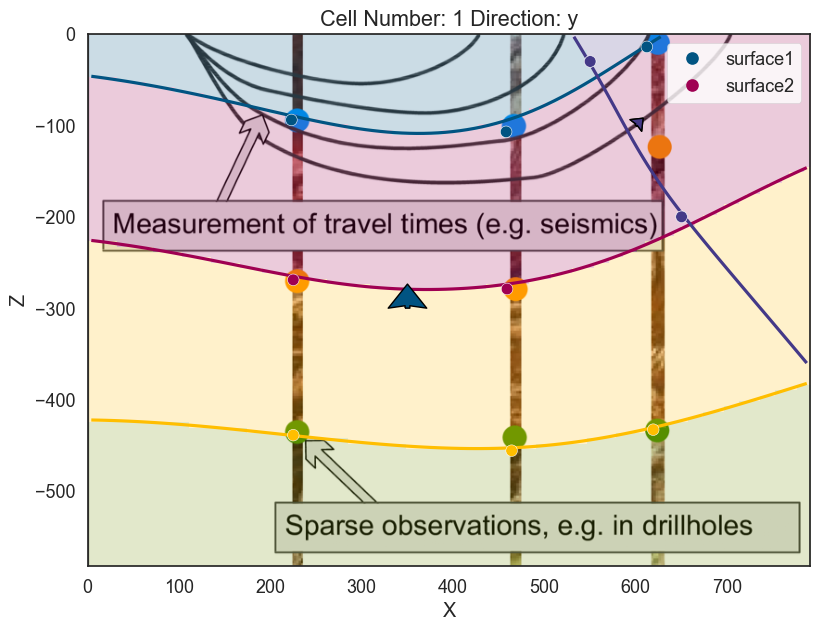

In [68]:
p2d.fig

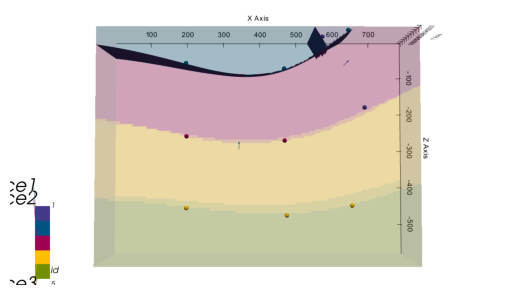

In [70]:
plot_pyvista_to_notebook(p3d.p)

### Fault

Then define that is a fault. It is possible to do this either by the `set_bottom_relation`
method or `set_is_fault`.

In [71]:
geo_model.set_is_fault('Discontinuity')

Fault colors changed. If you do not like this behavior, set change_color to False.


,order_series,BottomRelation,isActive,isFault,isFinite
Discontinuity,1,Fault,True,True,False
Default series,2,Erosion,True,False,False


And now is computing as before:

In [72]:
# Compute
gp.compute_model(geo_model)

# Plot
p2d.remove(ax)
p2d.plot_data(ax, cell_number=5)
p2d.plot_lith(ax, cell_number=5)
p2d.plot_contacts(ax, cell_number=5)

p3d.plot_data()
p3d.plot_surfaces()
p3d.plot_structured_grid(opacity=.2, annotations = {2: 'surface1', 3:'surface2',
                                                    4:'surface3', 5:'basement'})

[StructuredGrid (0x28f067aba00)
   N Cells:	88209
   N Points:	100000
   X Bounds:	3.955e+00, 7.870e+02
   Y Bounds:	1.000e+01, 1.900e+02
   Z Bounds:	-5.791e+02, -2.910e+00
   Dimensions:	100, 10, 100
   N Arrays:	3,

By using multiple series/features instead of having folding layers we can have sharp
 interfaces. This opens

## Additional features:

Over the years we have built a bunch of assets integrate with `gempy`.
 Here we will show some of them:

### Topography

GemPy has a built-in capabilities to read and manipulate topographic data (through gdal).
 To show an example we can just create a random topography:

In [73]:
## Adding random topography
geo_model.set_topography(source='random',
                         fd=1.9, d_z=np.array([-150, 0]),
                         resolution=np.array([200,200]))

Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[   3.955     ,   10.        , -579.09      ],
       [   3.955     ,   10.        , -573.27      ],
       [   3.955     ,   10.        , -567.45      ],
       ...,
       [ 791.        ,  197.98994975,  -54.02924024],
       [ 791.        ,  198.99497487,  -54.473154  ],
       [ 791.        ,  200.        ,  -54.83210375]])

The topography can we visualize in both renderers:

In [74]:
p2d.plot_topography(ax, cell_number=5)
p3d.plot_topography(scalars='topography')

(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)0000028F0037F280

But also allows us to compute the geological map of an area:

In [75]:
gp.compute_model(geo_model)
p3d.plot_surfaces()
p3d.plot_topography()

w:\miniconda\envs\gempy-tutorial\lib\site-packages\gempy\core\solution.py:174: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.geological_map = np.array(


(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)0000028F064B6220

In [76]:
p3d.plot_structured_grid()

[UnstructuredGrid (0x28f0037f580)
   N Cells:	80576
   N Points:	92702
   X Bounds:	3.955e+00, 7.870e+02
   Y Bounds:	1.000e+01, 1.900e+02
   Z Bounds:	-5.791e+02, -2.910e+00
   N Arrays:	3,

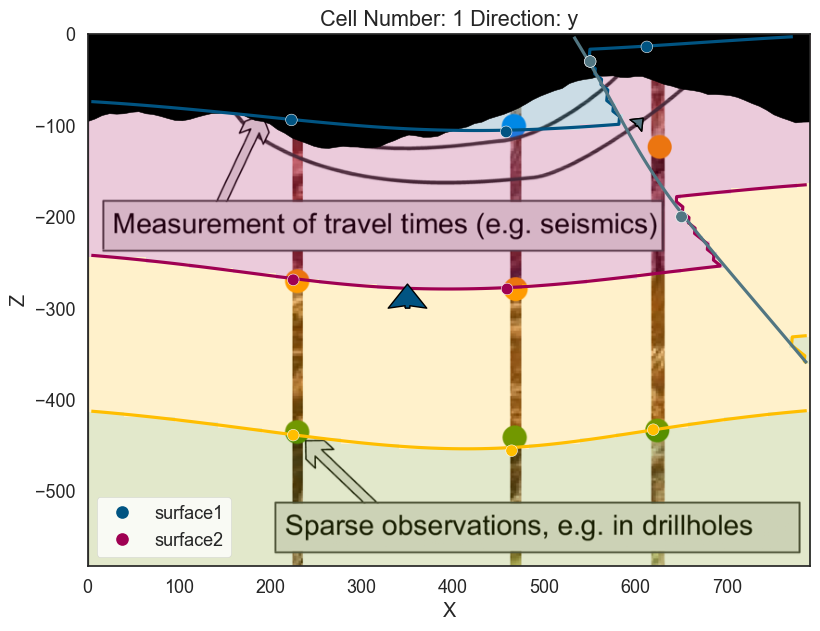

In [77]:
p2d.fig

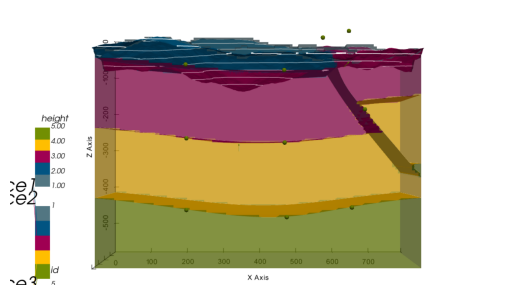

In [79]:
plot_pyvista_to_notebook(p3d.p)

--------------

<div class="alert alert-block alert-info"><b>Checkpoint:</b> Next cell will load the
model from disk to the necessary state to continue.</div>

# Part II: Subsurface to GemPy

For this notebook we will need some additional packages:

Extra:
`$ pip install subsurface, pooch, striplog, welly`


In [80]:
!pip install subsurface
!pip install pooch
!pip install git+https://github.com/Leguark/striplog.git
!pip install welly
!pip install sklearn

You should consider upgrading via the 'c:\users\legui\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\legui\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


  Cloning https://github.com/Leguark/striplog.git to c:\users\legui\appdata\local\temp\pip-req-build-t90fnu3u
Using legacy 'setup.py install' for striplog, since package 'wheel' is not installed.


You should consider upgrading via the 'c:\users\legui\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\legui\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\legui\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


## Subsurface: Centralizing data management for the GeoScientific Stack 

Subsurface is a package in development aiming to unify at a low level the data structures used from multilpe packages in geoscience for Python. It heavily relies on `xarray` to store data.

Besides the data structures themselves `subsurface` provides custom logic to read - and in the future write - to 3rd party formats outside the Python ecosystem. In this notebook we are going to use `subsurface` to import borehole data from csv files:

In [81]:
import pooch
from striplog import Component
import pandas as pd
import numpy as np

In [82]:
import subsurface as sb
from subsurface.reader import ReaderFilesHelper
from subsurface.reader.wells import read_collar, read_lith, read_survey, WellyToSubsurfaceHelper, welly_to_subsurface

We use `pooch` to download the dataset into a temp file:

In [92]:
url = "https://raw.githubusercontent.com/softwareunderground/subsurface/main/tests/data/borehole/kim_ready.csv"
known_hash = "efa90898bb435daa15912ca6f3e08cd3285311923a36dbc697d2aafebbafa25f"

# Your code here:
raw_borehole_data_csv = pooch.retrieve(url, known_hash)


Now we can use `subsurface` function to help us reading csv files into pandas dataframes that the package can understand. Since the combination of styles data is provided can highly vary from project to project, `subsurface` provides some *helpers* functions to parse different combination of .csv

In [93]:
reading_collars = ReaderFilesHelper(
        file_or_buffer=raw_borehole_data_csv,
        index_col="name",
        usecols=['x', 'y', 'altitude', "name"]
    )

reading_collars

ReaderFilesHelper(file_or_buffer='C:\\Users\\legui\\AppData\\Local\\pooch\\pooch\\Cache\\7c2d6aa7551f31216f7236d3f9fb70a6-kim_ready.csv', usecols=['x', 'y', 'altitude', 'name'], col_names=None, drop_cols=None, format='.csv', index_map=None, columns_map=None, additional_reader_kwargs={}, file_or_buffer_type=<class 'str'>, index_col='name', header='infer')

In [94]:
from dataclasses import asdict
asdict(reading_collars)

{'file_or_buffer': 'C:\\Users\\legui\\AppData\\Local\\pooch\\pooch\\Cache\\7c2d6aa7551f31216f7236d3f9fb70a6-kim_ready.csv',
 'usecols': ['x', 'y', 'altitude', 'name'],
 'col_names': None,
 'drop_cols': None,
 'format': '.csv',
 'index_map': None,
 'columns_map': None,
 'additional_reader_kwargs': {},
 'file_or_buffer_type': str,
 'index_col': 'name',
 'header': 'infer'}

In [95]:
collar = read_collar(reading_collars)

collar

,x,y,altitude
name,,,
KCL12,303412,3913997,108.713287
KCL12,303412,3913997,108.713287
KCL12,303412,3913997,108.713287
KCL12,303412,3913997,108.713287
KCL12,303412,3913997,108.713287
...,...,...,...
USLXX,318982,3935253,227.418152
USLXX,318982,3935253,227.418152
USLXX,318982,3935253,227.418152


In [96]:
# Your code here:
survey = read_survey(
    ReaderFilesHelper(
        file_or_buffer=raw_borehole_data_csv,
        index_col="name",
        usecols=["name", "md"]
    )
)

survey

w:\miniconda\envs\gempy-tutorial\lib\site-packages\subsurface\reader\wells\well_files_reader.py:132: UserWarning: inc and/or azi columns are not present in the file. The boreholes will be straight.
  warnings.warn('inc and/or azi columns are not present in the file.'


,md,inc,azi
name,,,
KCL12,0.000000,0,0
KCL12,1035.597076,0,0
KCL12,1652.245636,0,0
KCL12,2109.993683,0,0
KCL12,2109.984893,0,0
...,...,...,...
USLXX,308.885376,0,0
USLXX,601.202972,0,0
USLXX,753.114075,0,0


In [97]:
# Your code here:
lith = read_lith(
    ReaderFilesHelper(
        file_or_buffer=raw_borehole_data_csv,
        usecols=['name', 'top', 'base', 'formation'],
        columns_map={'top': 'top',
                     'base': 'base',
                     'formation': 'component lith',
                     }
    )
)

lith


,top,base,component lith
name,,,
KCL12,0.000000,1035.597076,topo
KCL12,1035.597076,1652.245636,etchegoin
KCL12,1652.245636,2109.993683,macoma
KCL12,2109.993683,2110.003683,mclure
KCL12,2109.984893,2799.027984,fruitvale
...,...,...,...
USLXX,308.885376,601.202972,freeman_jewett
USLXX,601.202972,753.114075,vedder
USLXX,753.114075,1197.413513,cretaceous


### Welly

Welly is a family of classes to facilitate the loading, processing, and analysis of subsurface wells and well data, such as striplogs, formation tops, well log curves, and synthetic seismograms.

We are using welly to convert pandas data frames into classes to manipulate well data. The final goal is to extract 3D coordinates and properties for multiple wells.

The class `WellyToSubsurfaceHelper` contains the methods to create a `welly` project and export it to a `subsurface` data class.

In [98]:
wts = sb.reader.wells.WellyToSubsurfaceHelper(collar_df=collar, survey_df=survey, lith_df=lith)

The following striplog failed being processed:  []


In the field p is stored a welly project (https://github.com/agile-geoscience/welly/blob/master/tutorial/04_Project.ipynb)and we can use it to explore and visualize properties of each well.

In [99]:
wts.p

Index,UWI,Data,Curves
0,Sharples_Marathon_BillingtonXX,2 curves,"lith, lith_log"
1,KCL12,2 curves,"lith, lith_log"
2,SUPERIOR_TENNECO_GAUTXX,2 curves,"lith, lith_log"
3,West_Rio_Bravo1,2 curves,"lith, lith_log"
4,Davies1,2 curves,"lith, lith_log"
5,KerncoXX,2 curves,"lith, lith_log"
6,R.A._Shafter_A1,2 curves,"lith, lith_log"
7,Shell_Magee_GlideXX,2 curves,"lith, lith_log"
8,Roberts_Cox23_1,2 curves,"lith, lith_log"
9,11,2 curves,"lith, lith_log"


In [100]:
stripLog = wts.p[0].data['lith']
stripLog

Striplog(10 Intervals, start=0.0, stop=4594.951477330001)

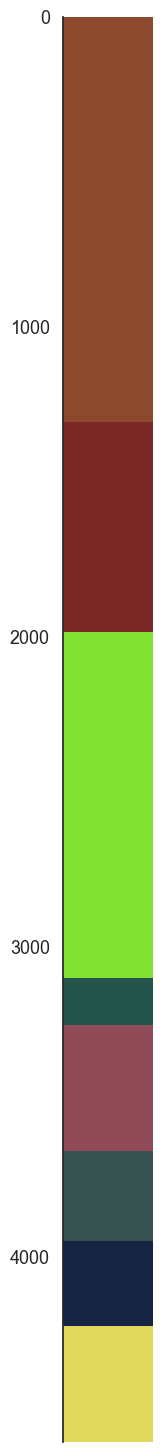

In [101]:
stripLog.plot()
plt.gcf()

In [102]:
welly_well = wts.p[0].data["lith_log"]
welly_well

Curve([1, 1, 1, 3, 2, 2, 2, 4, 6, 5])

## Welly to Subsurface 

Welly is a very powerful tool to inspect well data but it was not design for 3D. However they have a method to export XYZ coordinates of each of the well that we can take advanatage of to create a `subsurface.UnstructuredData` object. This object is one of the core data class of `subsurface` and we will use it from now on to keep working in 3D.

In [107]:
formations = ["topo", "etchegoin", "macoma", "chanac", "mclure",
              "santa_margarita", "fruitvale",
              "round_mountain", "olcese", "freeman_jewett", "vedder", "eocene",
              "cretaceous",
              "basement", "null"]

unstruct = sb.reader.wells.welly_to_subsurface(wts, table=[Component({'lith': l}) for l in formations])
unstruct.data

The following boreholes failed being processed:  []


<xarray.Dataset>
Dimensions:       (XYZ: 3, cell: 3283, cell_attr: 1, nodes: 2, points: 3350, vertex_attr: 0)
Coordinates:
  * points        (points) int64 0 1 2 3 4 5 6 ... 3344 3345 3346 3347 3348 3349
  * XYZ           (XYZ) <U1 'X' 'Y' 'Z'
  * cell_attr     (cell_attr) object 'lith_log'
  * vertex_attr   (vertex_attr) int64 
    UWI           (cell) object 'Sharples_Marathon_BillingtonXX' ... 'Arkelia...
    Depth         (cell) float64 46.89 140.7 234.4 ... 3.056e+03 3.12e+03
Dimensions without coordinates: cell, nodes
Data variables:
    vertex        (points, XYZ) float64 2.753e+05 3.947e+06 ... -3.036e+03
    cells         (cell, nodes) int32 0 1 1 2 2 3 ... 3347 3347 3348 3348 3349
    cell_attrs    (cell, cell_attr) int32 1 1 1 1 1 1 1 ... 13 13 13 13 13 14 14
    vertex_attrs  (points, vertex_attr) float64

At each core `UstructuredData` is a wrapper of a `xarray.Dataset`. Although slightly flexible, any `UnstructuredData` will contain 4 `xarray.DataArray` objects containing vertex, cells, cell attributes and vertex attibutes. This is the minimum amount of information necessary to work in 3D. 

From an `UnstructuredData` we can construct *elements*. *elements* are a higher level construct and includes the definion of type of geometric representation - e.g. points, lines, surfaces, etc. For the case of borehole we will use LineSets. *elements* have a very close relation to `vtk` data structures what enables easily to plot the data using `pyvista`

In [108]:
element = sb.LineSet(unstruct)
pyvista_mesh = sb.visualization.to_pyvista_line(element, radius=50)

# Plot default LITH
interactive_plot =sb.visualization.pv_plot([pyvista_mesh], background_plotter=True)

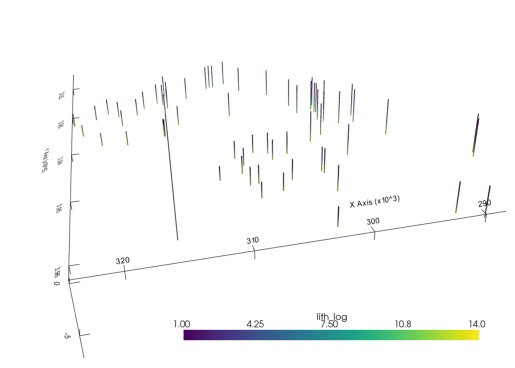

In [111]:
plot_pyvista_to_notebook(interactive_plot)

## Finding the boreholes bases

`GemPy` interpolates the bottom of a unit, therefore we need to be able to extract those points to be able tointerpolate them. `xarray`, `pandas` and `numpy` are using the same type of memory representation what makes possible to use the same or at least similar methods to manipulate the data to our will. 

Lets find the base points of each well:

In [112]:
# Creating references to the xarray.DataArray
cells_attr = unstruct.data.cell_attrs
cells = unstruct.data.cells
vertex = unstruct.data.vertex

In [113]:
# Find vertex points at the boundary of two units
# Marking each vertex
bool_prop_change = cells_attr.values[1:] != cells_attr.values[:-1]
# Getting the index of the vertex
args_prop_change = np.where(bool_prop_change)[0]
# Getting the attr values at those points 
vals_prop_change = cells_attr[args_prop_change]
vals_prop_change.to_pandas()

cell_attr,lith_log
cell,
0,1
1,2
2,3
3,5
4,8
...,...
590,6
591,9
592,10


In [114]:
# Getting the vertex values at those points
vertex_args_prop_change = cells[args_prop_change, 1]
interface_points = vertex[vertex_args_prop_change]
interface_points

<xarray.DataArray 'vertex' (cell: 595, XYZ: 3)>
array([[ 2.75307000e+05,  3.94707400e+06, -1.23919434e+03],
       [ 2.75307000e+05,  3.94707400e+06, -1.89603385e+03],
       [ 2.75307000e+05,  3.94707400e+06, -3.02167117e+03],
       ...,
       [ 3.05057000e+05,  3.92666500e+06, -2.07075398e+03],
       [ 3.05057000e+05,  3.92666500e+06, -2.45674741e+03],
       [ 3.05057000e+05,  3.92666500e+06, -2.90707307e+03]])
Coordinates:
    points   (cell) int64 14 21 33 35 39 42 43 ... 3323 3329 3333 3334 3340 3347
  * XYZ      (XYZ) <U1 'X' 'Y' 'Z'
    UWI      (cell) object 'Sharples_Marathon_BillingtonXX' ... 'Arkelian23_26'
    Depth    (cell) float64 1.266e+03 1.922e+03 ... 2.541e+03 2.991e+03
Dimensions without coordinates: cell

In [115]:
# Creating a new UnstructuredData
interf_us= sb.UnstructuredData.from_array(vertex=interface_points.values, cells="points",
                                          cells_attr=vals_prop_change.to_pandas())
interf_us

<xarray.Dataset>
Dimensions:       (XYZ: 3, cell: 595, cell_attr: 1, nodes: 1, points: 595, vertex_attr: 0)
Coordinates:
  * points        (points) int64 0 1 2 3 4 5 6 7 ... 588 589 590 591 592 593 594
  * XYZ           (XYZ) <U1 'X' 'Y' 'Z'
  * cell_attr     (cell_attr) object 'lith_log'
  * vertex_attr   (vertex_attr) int64 
    cell_         (cell) int64 0 1 2 3 4 5 6 7 ... 588 589 590 591 592 593 594
Dimensions without coordinates: cell, nodes
Data variables:
    vertex        (points, XYZ) float64 2.753e+05 3.947e+06 ... -2.907e+03
    cells         (cell, nodes) int32 0 1 2 3 4 5 6 ... 589 590 591 592 593 594
    cell_attrs    (cell, cell_attr) int32 1 2 3 5 8 9 12 13 ... 3 4 6 9 10 11 13
    vertex_attrs  (points, vertex_attr) float64 

This new `UnstructuredData` object instead containing data that represent lines, contain point data at the bottom of each unit. We can plot it very similar as before:

In [116]:
element = sb.PointSet(interf_us)
pyvista_mesh = sb.visualization.to_pyvista_points(element)
interactive_plot.add_mesh(pyvista_mesh)

(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)0000028F136BBE80

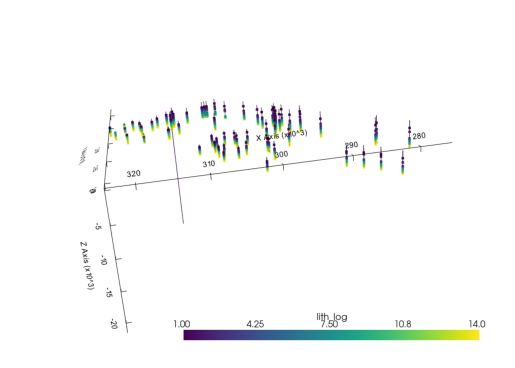

In [117]:
plot_pyvista_to_notebook(interactive_plot)

## GemPy: Initialize model

The first step to create a GemPy model is create a `gempy.Model` object that will
contain all the other data structures and necessary functionality. In addition
 for this example we will define a *regular grid* since the beginning.
This is the grid where we will interpolate the 3D geological model.

GemPy is based on a **meshless interpolator**. In practice this means that we can
interpolate any point in a 3D space. However, for convenience, we have built some
standard grids for different purposes. At the current day the standard grids are:

- **Regular grid**: default grid mainly for general visualization
- **Custom grid**: GemPy's wrapper to interpolate on a user grid
- **Topography**: Topographic data use to be of high density. Treating it as an independent
  grid allow for high resolution geological maps
- **Sections**: If we predefine the section 2D grid we can directly interpolate at those
  locations for perfect, high resolution estimations
- **Center grids**: Half sphere grids around a given point at surface. This are specially tuned
  for geophysical forward computations

In [118]:
import gempy as gp
extent= [275619, 323824, 3914125, 3961793, -3972.6, 313.922]

# Your code here:
geo_model = gp.create_model("getting started")
geo_model.set_regular_grid(extent=extent, resolution=[50,50,50])

Active grids: ['regular']


Grid Object. Values: 
array([[ 2.76101050e+05,  3.91460168e+06, -3.92973478e+03],
       [ 2.76101050e+05,  3.91460168e+06, -3.84400434e+03],
       [ 2.76101050e+05,  3.91460168e+06, -3.75827390e+03],
       ...,
       [ 3.23341950e+05,  3.96131632e+06,  9.95959000e+01],
       [ 3.23341950e+05,  3.96131632e+06,  1.85326340e+02],
       [ 3.23341950e+05,  3.96131632e+06,  2.71056780e+02]])

GemPy core code is written in Python. However for efficiency and gradient based
machine learning most of heavy computations happen in optimize compile code,
 either C or CUDA for GPU.

To do so, GemPy rely on the library `Theano`. To guarantee maximum optimization
`Theano` requires to compile the code for every Python kernel. The compilation is
done by calling the following line at any point (before computing the model):

In [119]:
gp.set_interpolator(geo_model, theano_optimizer='fast_compile', verbose=[])

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                            values
range                67928.893115
$C_o$            109865107.615631
drift equations               [3]


## Making a model step by step.

The temptation at this point is to bring all the points into `gempy` and just interpolate. However, often that strategy results in ill posed problems due to noise or irregularities in the data. `gempy` has been design to being able to iterate rapidly and therefore a much better workflow use to be creating the model step by step.

To do that, lets define a function that we can pass the name of the formation and get the assotiated vertex. Grab from the `interf_us` the XYZ coordinates of the first layer:

In [120]:
def get_interface_coord_from_surfaces(surface_names: list, verbose=False):
    
    df = pd.DataFrame(columns=["X", "Y", "Z", "surface"])
    
    for e, surface_name in enumerate(surface_names):
        # The properties in subsurface start at 1
        val_property = formations.index(surface_name) + 1
        # Find the cells with the surface id
        args_from_first_surface = np.where(vals_prop_change == val_property)[0]    
        if verbose: print(args_from_first_surface)
        # Find the vertex
        points_from_first_surface = interface_points[args_from_first_surface]
        if verbose: print(points_from_first_surface)
        
        # xarray.DataArray to pandas.DataFrame
        surface_pandas = points_from_first_surface.to_pandas()
        
        # Add formation column
        surface_pandas["surface"] = surface_name
        df = df.append(surface_pandas)
    
    return df.reset_index()

### Surfaces

GemPy is a surface based interpolator. This means that all the input data we add has to be refereed to a surface. The
 surfaces always mark the **bottom** of a unit. 
 
This is a list with the formations names for this data set.

In [121]:
formations

['topo',
 'etchegoin',
 'macoma',
 'chanac',
 'mclure',
 'santa_margarita',
 'fruitvale',
 'round_mountain',
 'olcese',
 'freeman_jewett',
 'vedder',
 'eocene',
 'cretaceous',
 'basement',
 'null']

Lets add the first two (remember we always need a basement defined).

In [122]:
geo_model.add_surfaces(formations[:2])

,surface,series,order_surfaces,color,id
0,topo,Default series,1,#015482,1
1,etchegoin,Default series,2,#9f0052,2


Using the function defined above we just extract the surface points for **topo**:

In [123]:
gempy_surface_points = get_interface_coord_from_surfaces(["topo"])
gempy_surface_points

,index,X,Y,Z,surface
0,0,275307.0,3947074.0,-1239.194335,topo
1,1,303412.0,3913997.0,-908.821649,topo
2,2,282689.0,3961793.0,-1052.765802,topo
3,3,289069.0,3928178.0,-1061.118302,topo
4,4,313907.0,3933224.0,-294.884646,topo
...,...,...,...,...,...
61,61,312385.0,3917847.0,-696.286883,topo
62,62,301307.0,3956909.0,-523.732696,topo
63,63,316551.0,3925747.0,-369.518215,topo
64,64,289500.0,3930121.0,-1078.632720,topo


And we can set them into the `gempy` model:

In [124]:
geo_model.set_surface_points(gempy_surface_points, update_surfaces=False)
geo_model.update_to_interpolator()

True

In [125]:
g2d = gp.plot_2d(geo_model)

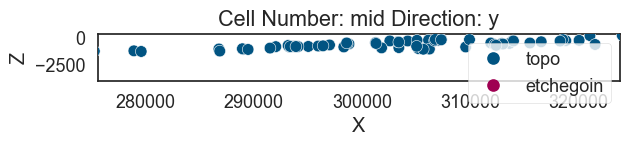

In [126]:
g2d.fig

The **minimum amount of input data** to interpolate anything in `gempy` is:

a) 2 surface points per surface

b) One orientation per series.

Lets add an orientation:

In [127]:
geo_model.add_orientations(X=300000, Y=3930000, Z=0, surface="topo", pole_vector=(0,0,1))

,X,Y,Z,G_x,G_y,G_z,smooth,surface
0,300000.0,3930000.0,0.0,0.0,0.0,1.0,0.01,topo


GemPy depends on multiple data objects to store all the data structures necessary
to construct an structural model. To keep all the necessary objects in sync the
class `gempy.ImplicitCoKriging` (which `geo_model` is instance of) will provide the
necessary methods to update these data structures coherently.

At current state (gempy 2.2), the data classes are:

- `gempy.SurfacePoints`
- `gempy.Orientations`
- `gempy.Surfaces`
- `gempy.Stack` (combination of `gempy.Series` and `gempy.Faults`)
- `gempy.Grid`
- `gempy.AdditionalData`
- `gempy.Solutions`

Today we will look into details only some of these classes but what is important
to notice is that you can access these objects as follows:

In [128]:
geo_model.additional_data

values
Structure isLith                                                                              True
          isFault                                                                            False
          number faults                                                                          0
          number surfaces                                                                        1
          number series                                                                          1
          number surfaces per series                                                           [1]
          len surfaces surface_points                                                         [66]
          len series surface_points                                                           [66]
          len series orientations                                                              [1]
Options   dtype                                                                            float64
          output                                                                           geology
          theano_optimizer                                                            fast_compile
          device                                                                               cpu
          verbosity                                                                             []
Kriging   range                                                                       67928.893115
          $C_o$                                                                   109865107.615631
          drift equations                                                                      [3]
Rescaling rescaling factor                                                                 97454.0
          centers                      [299670.50000000006, 3937895.000000002, -525.9590448304884]

In [129]:
gp.compute_model(geo_model)


Lithology ids 
  [2. 2. 2. ... 2. 2. 2.] 

In [130]:
g3d = gp.plot_3d(geo_model, plotter_type="background")

In [131]:
g3d.p.add_mesh(pyvista_mesh)

(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)0000028F7BBC5040

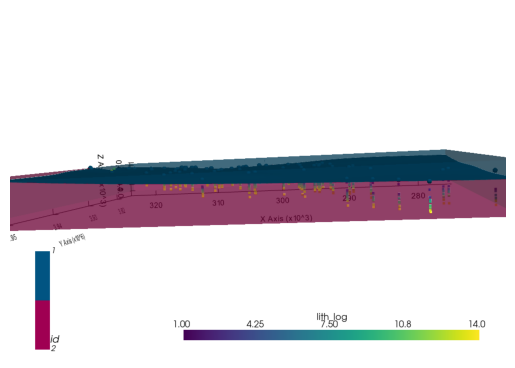

In [133]:
plot_pyvista_to_notebook(g3d.p)

## Second layer

In [134]:
geo_model.add_surfaces(formations[2])

,surface,series,order_surfaces,color,id
0,topo,Default series,1,#015482,1
1,etchegoin,Default series,2,#9f0052,2
2,macoma,Default series,3,#ffbe00,3


In [135]:
gempy_surface_points = get_interface_coord_from_surfaces(formations[:2])
geo_model.set_surface_points(gempy_surface_points, update_surfaces=False)
geo_model.update_to_interpolator()

True

In [136]:
gp.compute_model(geo_model)


Lithology ids 
  [1. 1. 1. ... 1. 1. 1.] 

In [137]:
live_plot = gp.plot_3d(geo_model, plotter_type="background", show_results=True)

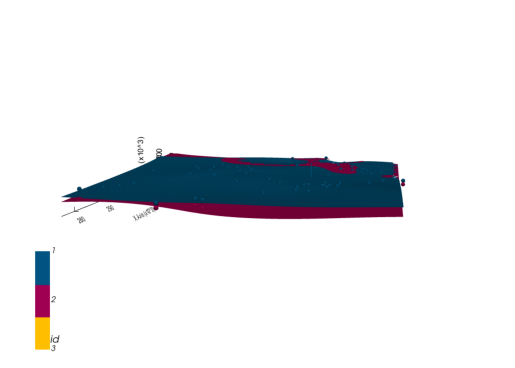

In [95]:
plot_pyvista_to_notebook(live_plot.p)

In [85]:
live_plot.toggle_live_updating()

True

### Trying to fix the model: Multiple Geo. Features/Series

In [138]:
geo_model.add_features("Formations")

,order_series,BottomRelation,isActive,isFault,isFinite
Default series,1,Erosion,True,False,False
Formations,2,Erosion,False,False,False


In [139]:
geo_model.map_stack_to_surfaces({"Form1": ["etchegoin", "macoma"]}, set_series=False)

,surface,series,order_surfaces,color,id
0,topo,Default series,1,#015482,1
1,etchegoin,Formations,1,#9f0052,2
2,macoma,Formations,2,#ffbe00,3


In [140]:
geo_model.add_orientations(X=300000, Y=3930000, Z=0, surface="etchegoin", pole_vector=(0,0,1), idx=1)

,X,Y,Z,G_x,G_y,G_z,smooth,surface
0,300000.0,3930000.0,0.0,0.0,0.0,1.0,0.01,topo
1,300000.0,3930000.0,0.0,0.0,0.0,1.0,0.01,etchegoin


In [141]:
gp.compute_model(geo_model)


Lithology ids 
  [3. 3. 3. ... 3. 3. 2.] 

In [142]:
h3d = gp.plot_3d(geo_model, plotter_type="background", show_lith=False, ve=5)

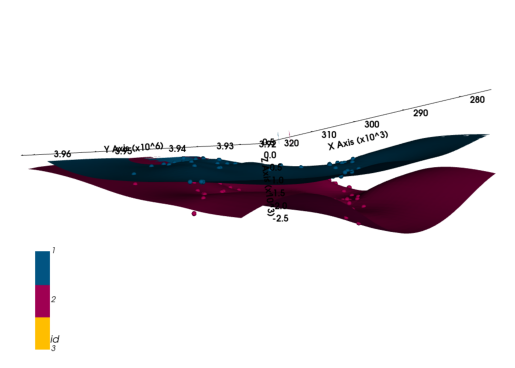

In [92]:
plot_pyvista_to_notebook(h3d.p)

## Last layers for today

In [143]:
geo_model.add_surfaces(formations[3:5])

,surface,series,order_surfaces,color,id
0,topo,Default series,1,#015482,1
1,etchegoin,Formations,1,#9f0052,2
2,macoma,Formations,2,#ffbe00,3
3,chanac,Formations,3,#728f02,4
4,mclure,Formations,4,#443988,5


In [144]:
f_last = formations[:4]
f_last

['topo', 'etchegoin', 'macoma', 'chanac']

In [145]:
gempy_surface_points = get_interface_coord_from_surfaces(f_last)
geo_model.set_surface_points(gempy_surface_points, update_surfaces=False)
geo_model.update_to_interpolator()

True

In [146]:
gp.compute_model(geo_model)


Lithology ids 
  [2. 2. 2. ... 2. 2. 2.] 

In [100]:
p3d_4 = gp.plot_3d(geo_model, plotter_type="background", show_lith=False, ve=5)

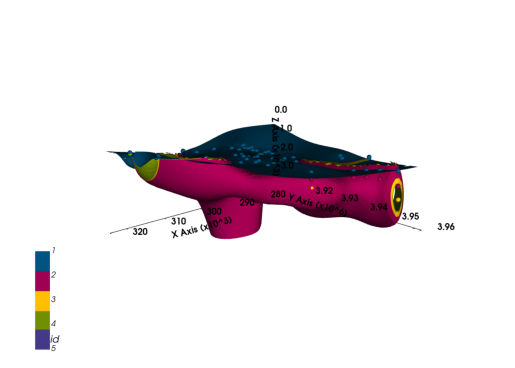

In [101]:
plot_pyvista_to_notebook(p3d_4.p)

In [102]:
geo_model.add_orientations(X=321687.059770, Y=3.945955e+06, Z=0, surface="etchegoin", pole_vector=(0,0,1), idx=1)
gp.compute_model(geo_model)
p3d_4.plot_surfaces()

{'topo': (vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000001F502C045E0,
 'etchegoin': (vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000001F502CA5FA0,
 'macoma': (vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000001F503552DC0,
 'chanac': (vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000001F55E62FB80}

In [103]:
geo_model.add_orientations(X=277278.652995, Y=3.929298e+06, Z=0, surface="etchegoin", pole_vector=(0,0,1), idx=2)
gp.compute_model(geo_model)
p3d_4.plot_surfaces()

{'topo': (vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000001F502CB29A0,
 'etchegoin': (vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000001F5035590A0,
 'macoma': (vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000001F55E4C6CA0,
 'chanac': (vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000001F55E62F160}

## Adding many more orientations

In [151]:
# find neighbours
neighbours = gp.select_nearest_surfaces_points(geo_model, geo_model._surface_points.df, 2)

# calculate all fault orientations
new_ori = gp.set_orientation_from_neighbours_all(geo_model, neighbours)
new_ori.df.head()

,X,Y,Z,X_c,Y_c,Z_c,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
0,300000.0,3930000.0,0.000000,0.503481,0.419087,0.514511,0.000000,0.000000,1.000000,0.000000,0.000000,1.0,topo,Default series,1,1.0,0.01
127,275307.0,3947074.0,-1239.194335,0.250100,0.594288,0.501795,0.034141,0.029117,0.998993,2.571777,49.540948,1.0,topo,Default series,1,1.0,0.01
128,303412.0,3913997.0,-908.821649,0.538492,0.254877,0.505185,0.102544,-0.071038,0.992189,7.166131,124.712688,1.0,topo,Default series,1,1.0,0.01
129,282689.0,3961793.0,-1052.765802,0.325849,0.745323,0.503708,-0.013726,-0.008014,0.999874,0.910736,239.721254,1.0,topo,Default series,1,1.0,0.01
130,289069.0,3928178.0,-1061.118302,0.391315,0.400391,0.503623,-0.063321,0.023040,0.997727,3.863660,289.994106,1.0,topo,Default series,1,1.0,0.01


In [152]:
gp.compute_model(geo_model)


Lithology ids 
  [2. 2. 2. ... 5. 5. 5.] 

In [106]:
p3d_4.plot_orientations()
p3d_4.plot_surfaces()

{'topo': (vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000001F559AB40A0,
 'etchegoin': (vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000001F55E62FEE0,
 'macoma': (vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000001F55E62F520,
 'chanac': (vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000001F50354FFA0}

In [107]:
p3d_4.p.add_mesh(pyvista_mesh)


(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000001F502CA5FA0

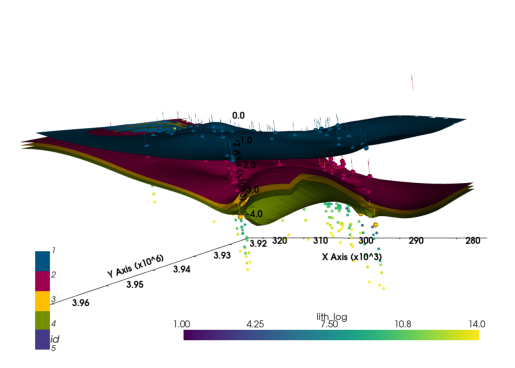

In [108]:
plot_pyvista_to_notebook(p3d_4.p)

-----

## Thank you for your attention


#### Extra Resources

Page:
https://www.gempy.org/

Paper:
https://www.gempy.org/theory

Gitub:
https://github.com/cgre-aachen/gempy

#### Further training and collaborations
https://www.terranigma-solutions.com/

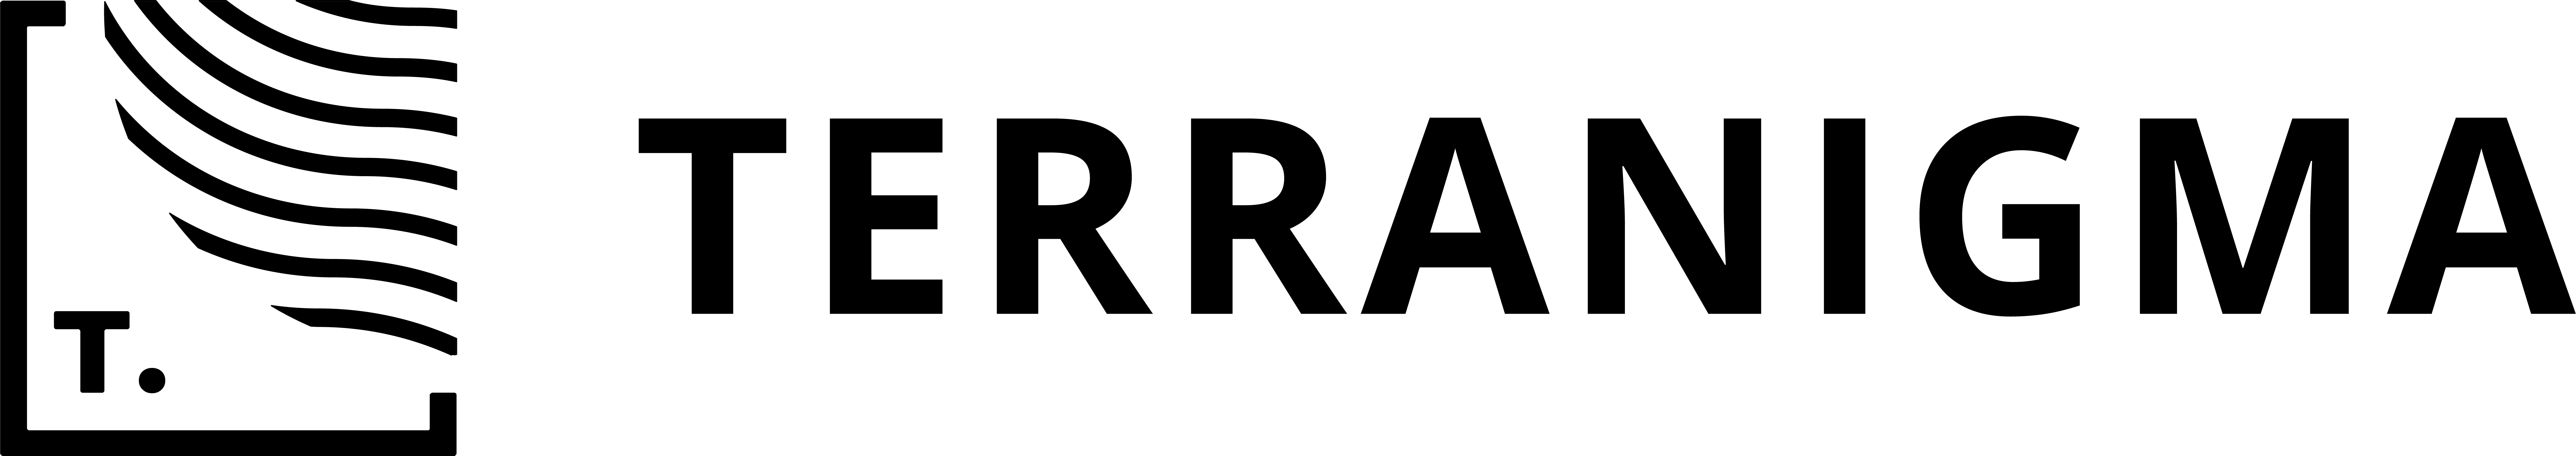

